In [1]:
from dataset_for_centercrop import Radiate_Dataset
from PIL import Image
import cv2
import numpy as np
import torch
import argparse
import os


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_folder", help="root folder with radiate dataset", 
                    default='/workspace/dataset/radiate', type=str)

parser.add_argument("--save_folder", help="root for save directory",
                    default = "/workspace/JS/faster_rcnn_JS/checkpoint", type=str)

parser.add_argument("--backbone", help="backbone network",
                    default='VGG16', type=str)

parser.add_argument("--mgpu", help="using multigpu",
                    default=False, type=bool)

parser.add_argument("--train_mode", help="dataset mode ('train_good_weather', 'train_good_and_bad_weather', 'test')",
                    default='train_good_and_bad_weather', type=str)

parser.add_argument("--checkpoint", help="checkpoint root",
                    default=None, type=str)

parser.add_argument("--batch_size", help="batch size",
                    default=4, type=int)

parser.add_argument("--num_workers", help="number of workers for loading data in the DataLoader",
                    default=8, type=int)

parser.add_argument("--save_rate", help="save rate for the model",
                    default=5000, type=int)

parser.add_argument("--max_iter", help="Maximum number of iterations",
                    default = 50000, type=int)

parser.add_argument("--loss_lambda", help="loss balance coefficient",
                    default=1, type=int)

parser.add_argument("--lr", help="learning rate",
                    default=0.00025, type=float)

parser.add_argument("--momentum", help="momentum",
                    default=0.9, type=float)

parser.add_argument("--weight_decay", help="weight decay",
                    default=0.0001, type=float)

parser.add_argument("--GAMMA", help="lr GAMMA",
                    default=0.1, type=float)

parser.add_argument("--decay_step", help="steps for decay lr",
                    default=[25000, 35000], type=list)


args = parser.parse_args(args=[])
data_folder = args.data_folder
train_mode = args.train_mode

save_folder = args.save_folder
backbone = args.backbone
checkpoint = args.checkpoint
mgpu = args.mgpu

batch_size = args.batch_size
workers = args.num_workers
max_iteration = args.max_iter
save_rate = args.save_rate

loss_lambda = args.loss_lambda
momentum = args.momentum
lr = args.lr
weight_decay = args.weight_decay
decay_step = args.decay_step
decay_GAMMA = args.GAMMA

In [3]:
def gen_boundingbox(bbox, angle):
    theta = np.deg2rad(-angle)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    
    x1 = bbox[0] - bbox[2] / 2
    y1 = bbox[1] - bbox[3] / 2
    x2 = bbox[0] + bbox[2] / 2
    y2 = bbox[1] + bbox[3] / 2
    
    points = np.array([[x1, y1],
                       [x2, y1],
                       [x2, y2],
                       [x1, y2]]).T

    cx = bbox[0]
    cy = bbox[1]

    T = np.array([[cx], [cy]])

    points = points - T
    points = np.matmul(R, points) + T
    points = points.astype(float)
    
    return points

(5,)


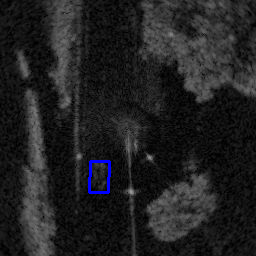

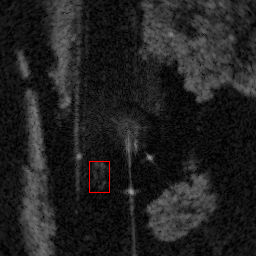

In [82]:
train_mode = 'train_good_and_bad_weather'
root_dir = '/workspace/dataset/radiate_centercrop'
# dataset = Radiate_Dataset(data_folder, train_mode, transform=True)

img_list = np.loadtxt(os.path.join(root_dir, train_mode, 'labels_with_object.txt'))
# print(img_list[110])
i = int(img_list[2012])

img_save = os.path.join(root_dir, train_mode, 'images')
label_save = os.path.join(root_dir, train_mode, 'labels')
label_angle_save = os.path.join(root_dir, train_mode, 'labels_angle')
label_OBB_save = os.path.join(root_dir, train_mode, 'labelTxt')
img_info_save = os.path.join(root_dir, train_mode, 'img_info')

img = cv2.imread(os.path.join(img_save, str(i).zfill(5)+'.png'))
labels = np.loadtxt(os.path.join(label_save, str(i).zfill(5)+'.txt'),dtype = np.float32)
labels_angle = np.loadtxt(os.path.join(label_angle_save, str(i).zfill(5)+'.txt'),dtype = str)
labels_OBB = np.loadtxt(os.path.join(label_OBB_save,str(i).zfill(5)+'.txt'), dtype=str)
print(labels.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = img.copy()
try:
    temp_OBB = labels_OBB[:,0:8]
    temp_angle = labels_angle[:,0:5]
    # print(temp_angle)
    bbox = temp_OBB.astype(np.float32)
    bbox = bbox.astype(np.int32)
    bbox_angle = temp_angle.astype(np.float32)
    for i, label in enumerate(labels):
        x_min = label[1] - label[3] / 2
        x_max = label[1] + label[3] / 2
        y_min = label[2] - label[4] / 2
        y_max = label[2] + label[4] / 2
        cv2.line(img, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), (0,0,255), 2)
        cv2.line(img, (bbox[i][2], bbox[i][3]), (bbox[i][4], bbox[i][5]), (0,0,255), 2)
        cv2.line(img, (bbox[i][4], bbox[i][5]), (bbox[i][6], bbox[i][7]), (0,0,255), 2)
        cv2.line(img, (bbox[i][6], bbox[i][7]), (bbox[i][0], bbox[i][1]), (0,0,255), 2)
        x_min, y_min, x_max, y_max = np.int32(x_min), np.int32(y_min), np.int32(x_max), np.int32(y_max)
       
        # points = gen_boundingbox(bbox_angle[i, 0:4], bbox_angle[i, 4])
        # points = points.astype(np.int32)
        # # print(points.shape)
        # cv2.line(img2, (points[0][0], points[1][0]), (points[0][1], points[1][1]), (0,255,0), 2)
        # cv2.line(img2, (points[0][1], points[1][1]), (points[0][2], points[1][2]), (0,255,0), 2)
        # cv2.line(img2, (points[0][2], points[1][2]), (points[0][3], points[1][3]), (0,255,0), 2)
        # cv2.line(img2, (points[0][3], points[1][3]), (points[0][0], points[1][0]), (0,255,0), 2)
        # print(bbox[i] == points.T.reshape(-1))
        # print(bbox[i])
        # print(points.T.reshape(-1))
        
        cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (255,0,0), 1)
        
    img1_show = Image.fromarray(img)
    img2_show = Image.fromarray(img2)
    img1_show.show()
    img2_show.show()
except:
    if labels.shape[0] == 5:
        temp_OBB = labels_OBB[0:8]
        temp_angle = labels_angle[0:5]
        # print(temp_angle)
        bbox = temp_OBB.astype(np.float32)
        bbox = bbox.astype(np.int32)
        bbox_angle = temp_angle.astype(np.float32)
        x_min = labels[1] - labels[3] / 2
        x_max = labels[1] + labels[3] / 2
        y_min = labels[2] - labels[4] / 2
        y_max = labels[2] + labels[4] / 2
        cv2.line(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 2)
        cv2.line(img, (bbox[2], bbox[3]), (bbox[4], bbox[5]), (0,0,255), 2)
        cv2.line(img, (bbox[4], bbox[5]), (bbox[6], bbox[7]), (0,0,255), 2)
        cv2.line(img, (bbox[6], bbox[7]), (bbox[0], bbox[1]), (0,0,255), 2)
        x_min, y_min, x_max, y_max = np.int32(x_min), np.int32(y_min), np.int32(x_max), np.int32(y_max)
       
        # points = gen_boundingbox(bbox_angle[i, 0:4], bbox_angle[i, 4])
        # points = points.astype(np.int32)
        # # print(points.shape)
        # cv2.line(img2, (points[0][0], points[1][0]), (points[0][1], points[1][1]), (0,255,0), 2)
        # cv2.line(img2, (points[0][1], points[1][1]), (points[0][2], points[1][2]), (0,255,0), 2)
        # cv2.line(img2, (points[0][2], points[1][2]), (points[0][3], points[1][3]), (0,255,0), 2)
        # cv2.line(img2, (points[0][3], points[1][3]), (points[0][0], points[1][0]), (0,255,0), 2)
        # print(bbox[i] == points.T.reshape(-1))
        # print(bbox[i])
        # print(points.T.reshape(-1))
        
        cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (255,0,0), 1)
        
    img1_show = Image.fromarray(img)
    img2_show = Image.fromarray(img2)
    img1_show.show()
    img2_show.show()

In [10]:
train_mode = 'test'
root_dir = '/workspace/dataset/radiate_centercrop'

img_root = os.path.join(root_dir, train_mode, 'images')
img_list = os.listdir(img_root)
img_list.sort()
print(len(img_list))

11307
